In [1]:
import zipfile
import os


zip_path = '/content/drive/MyDrive/fashion-dataset/fashion-dataset.zip'
extract_path = '/content/fashion_data'

# Unzip it
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted!")


✅ Dataset extracted!


In [2]:

!pip install swifter
!pip install torchvision
!pip install opencv-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16505 sha256=6b13fa6f0e0d9d6bf669b2a3524dbbdce765fddf7e7a29851e59b21ade1ff8bb
  Stored in directory: /root/.cache/pip/wheels/d9/31/ff/ff51141a088571a9f672449e5aad5ea8bb35ca5d95ba135f30
Successfully built swifter


In [5]:


# Importing matplotlib for plotting
import matplotlib.pyplot as plt

# Importing numpy for numerical operations
import numpy as np

# Importing pandas for preprocessing
import pandas as pd

# Importing joblib to dump and load embeddings df
import joblib

# Importing cv2 to read images
import cv2

# Importing cosine_similarity to find similarity between images
from sklearn.metrics.pairwise import cosine_similarity

# Importing flatten from pandas to flatten 2-D array
from pandas.core.common import flatten

# Importing the below libraries for our model building
import torch
import torch.nn as nn

# Importing pretrained models
import torchvision.models as models
import torchvision.transforms as transforms

# Import autograd
from torch.autograd import Variable

# To read images
from PIL import Image

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [6]:


# Load CSV file
df = pd.read_csv('/content/fashion_data/styles.csv', on_bad_lines='skip')



df.head(10)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012.0,Casual,Jealous 21 Women Purple Shirt
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012.0,Casual,Puma Men Pack of 3 Socks
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Skagen Men Black Watch


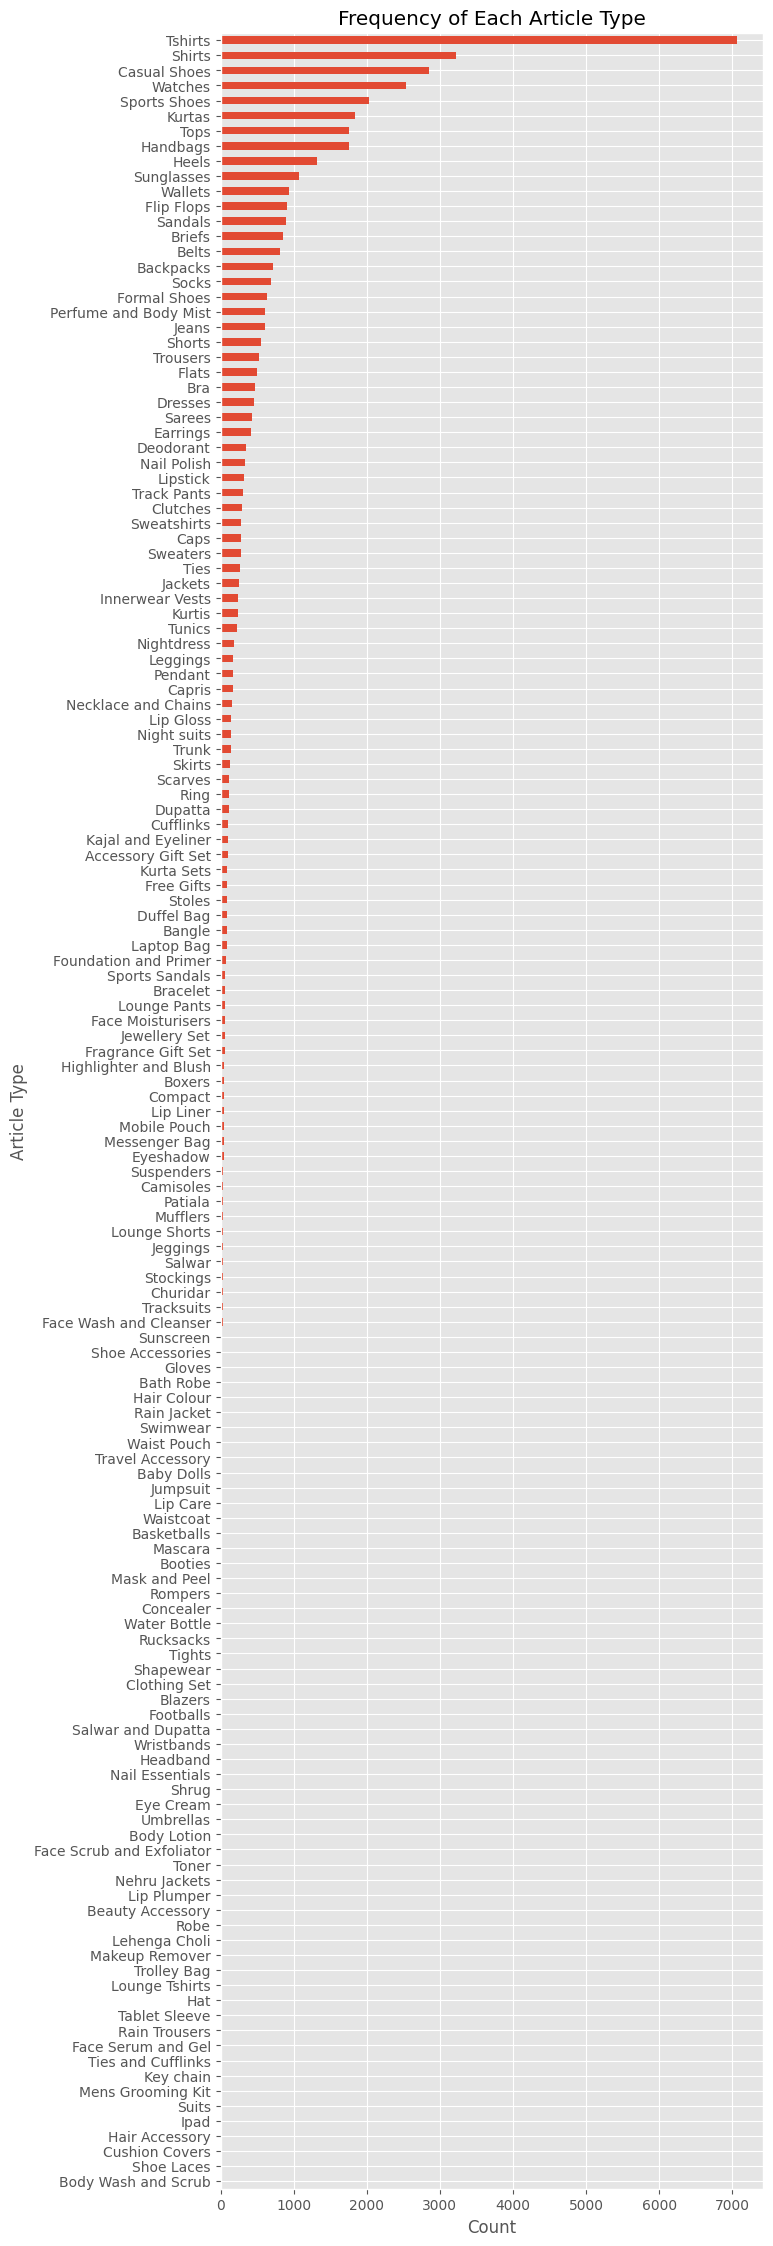

In [7]:


# Set plot style
plt.style.use('ggplot')

# Plot count of each articleType
plt.figure(figsize=(7, 28))
df.articleType.value_counts().sort_values().plot(kind='barh')
plt.title("Frequency of Each Article Type")
plt.xlabel("Count")
plt.ylabel("Article Type")
plt.show()


In [8]:

df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)

# Reset index
df = df.reset_index(drop=True)


df.head()


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg


In [9]:
# Define image location function
def image_location(img):
    return '/content/fashion_data/images/' + img

# Function to import image using OpenCV
def import_img(image):
    image = cv2.imread(image_location(image))
    return image

# Function to show a grid of images
def show_images(images, rows=1, cols=1, figsize=(12, 12)):
    fig, axes = plt.subplots(ncols=cols, nrows=rows, figsize=figsize)

    for index, name in enumerate(images):
        axes.ravel()[index].imshow(cv2.cvtColor(images[name], cv2.COLOR_BGR2RGB))
        axes.ravel()[index].set_title(name)
        axes.ravel()[index].set_axis_off()

    plt.tight_layout()


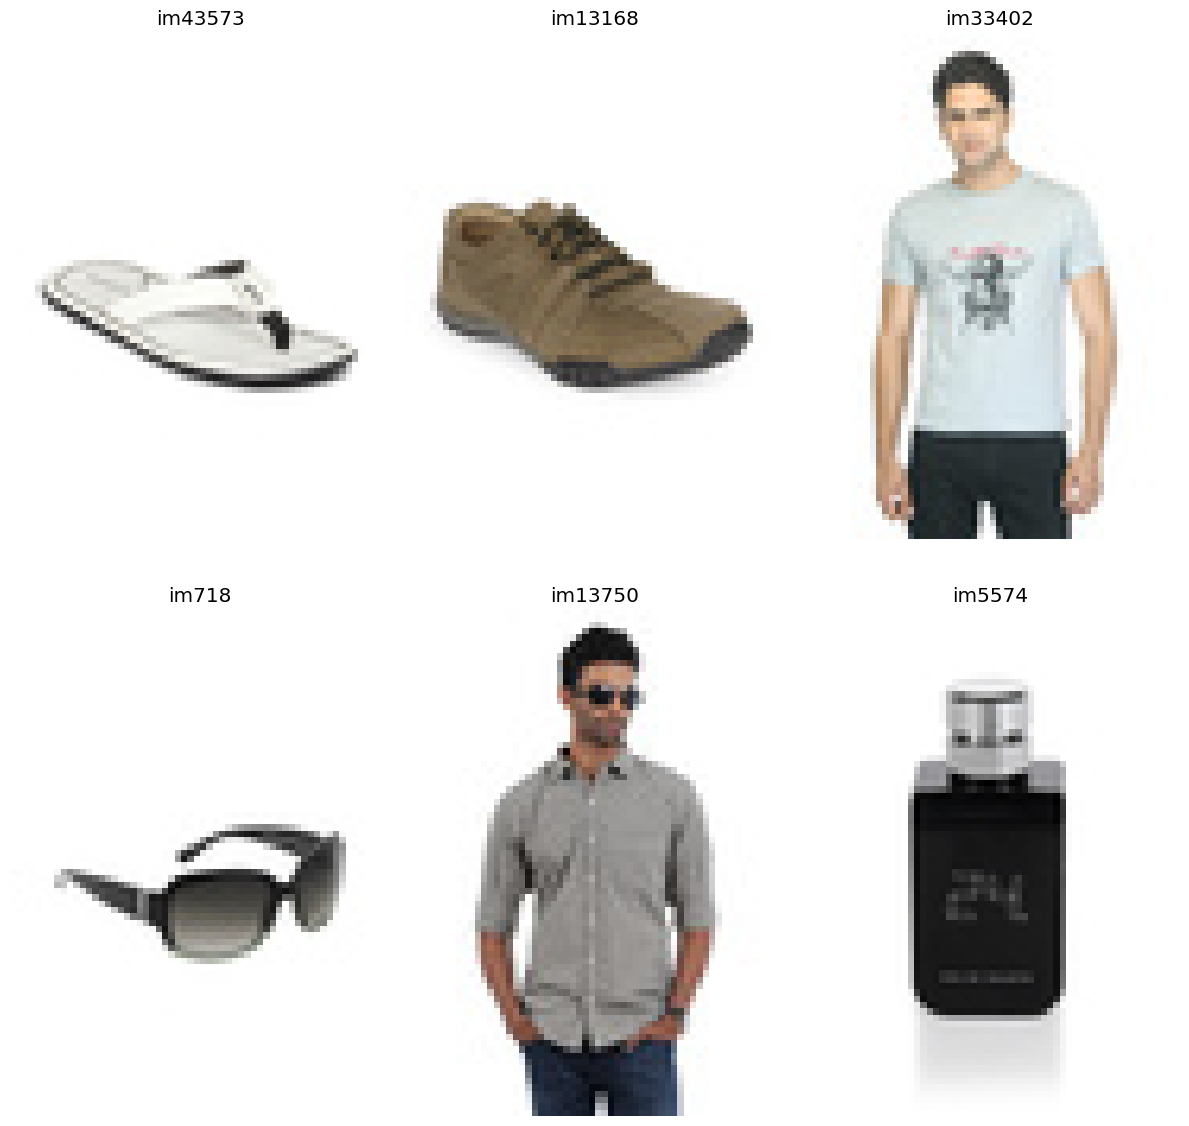

In [10]:
#  Display 6 random images from dataset

# Dictionary of {title: image array}
figures = {'im' + str(i): import_img(row.image) for i, row in df.sample(6).iterrows()}

# Show in grid (2 rows, 3 cols)
show_images(figures, 2, 3)


In [11]:
#  Set input size for ResNet
width = 224
height = 224

# Load pretrained ResNet18 model
resnetmodel = models.resnet18(pretrained=True)

# Select the last avgpool layer
layer = resnetmodel._modules.get('avgpool')

# Set to evaluation mode
resnetmodel.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
#  Define image transforms
resize = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.7, 0.6, 0.3], std=[0.2, 0.3, 0.1])
to_tensor = transforms.ToTensor()

# List to store images we couldn't load
missing_img = []

# Function to extract 512-dim embedding
def vector_extraction(resnetmodel, image_id):
    try:
        # Load image and convert to RGB
        img = Image.open(image_location(image_id)).convert('RGB')

        # Apply transforms
        img_t = resize(img)
        img_t = to_tensor(img_t)
        img_t = normalize(img_t)
        img_t = Variable(img_t.unsqueeze(0))  # Add batch dimension

        # Placeholder for output
        embeddings = torch.zeros(512)

        # Define hook function
        def copy_data(m, i, o):
            embeddings.copy_(o.data.reshape(o.data.size(1)))

        # Register forward hook
        hook = layer.register_forward_hook(copy_data)

        # Forward pass
        resnetmodel(img_t)

        # Remove hook
        hook.remove()

        return embeddings

    except FileNotFoundError:
        # Track missing images
        missing_index = df[df['image'] == image_id].index
        print(f"Missing image: {image_id}, at index: {missing_index}")
        missing_img.append(missing_index)


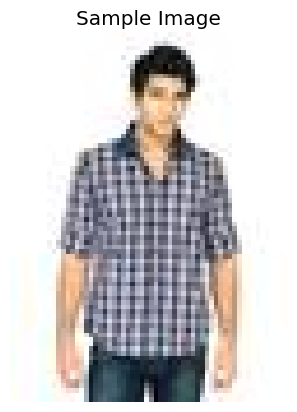

Image shape: (80, 60, 3)
Embedding vector (length = 512):
tensor([3.4817e-01, 1.0096e+00, 2.3027e-01, 1.6094e+00, 3.1613e-01, 8.5980e-01,
        4.3306e-01, 1.1168e-01, 1.8218e+00, 1.4897e+00, 1.9399e-01, 8.2331e-01,
        5.5605e-01, 8.9922e-02, 1.8818e-02, 1.3682e-01, 9.4701e-01, 1.0497e-01,
        1.6656e-01, 1.7626e+00, 9.9358e-01, 1.3072e+00, 2.1264e+00, 4.9266e-01,
        1.2562e-01, 2.7388e-01, 6.8457e-01, 3.1402e+00, 6.9369e-02, 4.8552e-01,
        8.1938e-01, 3.3273e-01, 3.4622e-01, 2.4428e+00, 9.3075e-01, 1.1730e+00,
        4.7562e-01, 3.6370e-01, 8.1940e-01, 5.6768e-01, 4.4987e-01, 2.3003e-01,
        1.2730e-01, 1.4716e+00, 2.5265e+00, 2.6488e-01, 1.1693e-01, 3.0466e-01,
        2.3547e+00, 5.5900e-01, 1.4455e+00, 1.1469e+00, 6.1637e-01, 5.6348e-01,
        7.1206e-01, 6.7012e-01, 1.3783e-01, 3.5957e+00, 9.4734e-01, 1.3985e+00,
        2.7163e-01, 5.2888e-01, 5.6491e-01, 5.8260e-01, 1.7505e-01, 4.6431e-02,
        1.2812e+00, 3.6965e-01, 1.1536e+00, 1.3511e+00, 8.4561

In [13]:
#  Test on first image in dataset
sample_embedding_0 = vector_extraction(resnetmodel, df.iloc[0].image)

# Load image using OpenCV for display
img_array = import_img(df.iloc[0].image)

# Plot image
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Sample Image')
plt.show()

# Print image shape and embedding vector
print("Image shape:", img_array.shape)
print("Embedding vector (length = {}):".format(len(sample_embedding_0)))
print(sample_embedding_0)


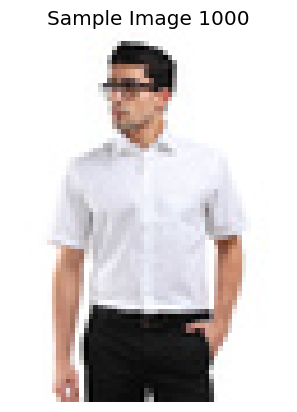

Image shape: (80, 60, 3)
Embedding vector length: 512
tensor([2.2214e-01, 4.8201e-01, 1.4577e+00, 2.0319e+00, 7.2153e-02, 1.1472e+00,
        3.7525e-01, 1.2374e-01, 1.2103e+00, 1.6589e+00, 4.6383e-01, 1.1207e+00,
        1.8760e-01, 1.6882e-01, 7.9731e-02, 9.6742e-01, 3.4295e-01, 6.1189e-01,
        1.4849e-01, 2.1886e+00, 4.2695e-01, 7.3654e-01, 2.2325e+00, 7.4542e-01,
        3.7189e-01, 2.1022e-01, 2.0852e-01, 3.8510e+00, 0.0000e+00, 7.6034e-01,
        5.2886e-01, 5.1996e-02, 4.3434e-01, 2.9405e+00, 3.0286e+00, 7.1146e-02,
        5.4160e-01, 1.2275e-01, 1.0301e+00, 8.6784e-01, 2.9940e-01, 2.2237e-01,
        2.0470e-01, 5.1393e-01, 8.8564e-01, 1.4416e+00, 4.1729e-01, 1.9291e-01,
        1.4389e+00, 4.5813e-01, 2.1016e+00, 1.2736e+00, 2.7155e-01, 5.5243e-01,
        7.0722e-01, 9.0096e-01, 3.1049e-02, 1.2802e+00, 7.3365e-01, 5.1611e-01,
        2.2345e-01, 1.3885e-01, 1.7405e+00, 1.2096e+00, 5.0332e-01, 7.8591e-01,
        1.8049e+00, 2.8785e-02, 4.2256e-01, 9.1533e-01, 1.3768e+00

In [14]:
# Extract embedding for 1000th image in dataset
sample_embedding_1 = vector_extraction(resnetmodel, df.iloc[1000].image)

# Load image and plot
img_array = import_img(df.iloc[1000].image)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Sample Image 1000')
plt.show()

# Print shape and embedding vector
print("Image shape:", img_array.shape)
print("Embedding vector length:", len(sample_embedding_1))
print(sample_embedding_1)


In [15]:
from sklearn.metrics.pairwise import cosine_similarity

cos_sim = cosine_similarity(sample_embedding_0.unsqueeze(0), sample_embedding_1.unsqueeze(0))
print('\nCosine similarity: {0}\n'.format(cos_sim))



Cosine similarity: [[0.8664364]]



In [17]:
import swifter

# Use a smaller dataset for testing
df_embeddings = df.iloc[:5000].copy()

# Apply vector extraction
map_embeddings = df_embeddings['image'].swifter.apply(lambda img: vector_extraction(resnetmodel, img))

# Convert each embedding (assumed to be a list or tensor) to a row
df_embs = map_embeddings.apply(pd.Series)

print(df_embs.shape)
df_embs.head()



Pandas Apply:   0%|          | 0/5000 [00:00<?, ?it/s]

(5000, 512)


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.348166,1.009573,0.230270,1.609439,0.316126,0.859798,0.433056,0.111684,1.821786,1.489676,...,0.605075,0.910010,2.286938,0.562117,0.002573,0.157162,1.885742,1.420860,0.000000,0.504326
1,0.754325,0.232688,0.522141,2.608785,0.838684,0.135893,0.427806,0.854114,0.601941,2.225887,...,0.222548,0.424173,0.006582,0.189141,0.000000,0.156890,1.189895,0.405764,0.087879,0.134553
2,0.331701,0.240246,3.068739,2.655945,0.009184,0.013016,3.198415,0.591137,3.220151,4.040012,...,0.303095,3.104078,1.619334,0.973719,0.458845,0.000000,1.401981,0.908382,0.000000,0.000000
3,0.624760,0.258359,0.544933,2.922386,0.353659,0.141807,0.799509,0.617607,0.298829,0.843659,...,0.320797,0.392779,0.261849,0.159667,0.000000,0.005314,0.677280,0.223054,0.063506,0.190920
4,0.452777,0.649997,0.348728,1.654590,0.135157,1.385382,0.481831,0.515382,2.859257,1.028548,...,0.432273,0.875068,1.472378,0.889062,0.074484,0.321773,1.748126,0.052523,0.000000,0.241553


In [18]:
# Export embeddings to CSV
df_embs.to_csv('df_embs.csv')

# Load embeddings back (for example)
df_embs = pd.read_csv('df_embs.csv')

# Drop unnecessary columns from CSV import
df_embs.drop(['Unnamed: 0', 'index'], axis=1, inplace=True, errors='ignore')

# Drop any rows with missing values
df_embs.dropna(inplace=True)

# Export as pickle for faster loading
import joblib
joblib.dump(df_embs, 'df_embs.pkl', compress=9)

# Load pickle file (example)
df_embs = joblib.load('df_embs.pkl')


In [19]:
# Calculating cosine similarity matrix for all image embeddings
cosine_sim = cosine_similarity(df_embs)

# Preview first 4x4 of the similarity matrix to verify structure
print(cosine_sim[:4, :4])


[[1.         0.74293589 0.61761071 0.77090675]
 [0.74293589 1.         0.63943804 0.87482628]
 [0.61761071 0.63943804 1.         0.60487401]
 [0.77090675 0.87482628 0.60487401 1.        ]]


In [20]:
# Create a pandas Series mapping df indices to themselves (for easy lookups)
index_vales = pd.Series(range(len(df)), index=df.index)
print(index_vales.head())


0    0
1    1
2    2
3    3
4    4
dtype: int64


In [21]:
def recommend_images(ImId, df, top_n=6):
    # Get index of image to find recommendations for
    sim_ImId = index_vales[ImId]

    # List of tuples (image index, similarity score) for all images relative to sim_ImId
    sml_scr = list(enumerate(cosine_sim[sim_ImId]))

    # Sort by similarity score descending
    sml_scr = sorted(sml_scr, key=lambda x: x[1], reverse=True)

    # Get top_n+1 (excluding first one because it is the same image)
    sml_scr = sml_scr[1:top_n+1]

    # Extract image indices and similarity scores separately
    ImId_rec = [i[0] for i in sml_scr]
    ImId_sim = [i[1] for i in sml_scr]

    # Return actual DataFrame indices and similarity scores
    return index_vales.iloc[ImId_rec].index, ImId_sim


In [22]:
recommended_indices, similarity_scores = recommend_images(3810, df, top_n=5)
print(recommended_indices)
print(similarity_scores)


Index([0, 3899, 634, 3678, 4746], dtype='int64')
[np.float64(0.9668129761808045), np.float64(0.9621247375124131), np.float64(0.959359857617911), np.float64(0.9575349981664343), np.float64(0.9552211823546555)]


In [23]:
def Rec_viz_image(input_imageid):
    # Get recommendations indices and similarity scores
    idx_rec, idx_sim = recommend_images(input_imageid, df, top_n=6)

    # Print similarity scores
    print(idx_sim)

    # Show the query/input image
    plt.figure(figsize=(4,4))
    plt.imshow(cv2.cvtColor(import_img(df.iloc[input_imageid].image), cv2.COLOR_BGR2RGB))
    plt.title(f"Input Image ID: {input_imageid}")
    plt.axis('off')
    plt.show()

    # Generate dictionary of images for recommendations
    figures = {'im'+str(i): import_img(row.image) for i, row in df.loc[idx_rec].iterrows()}

    # Show recommended images in 2 rows x 3 columns grid
    show_images(figures, rows=2, cols=3)


[np.float64(0.9668129761808045), np.float64(0.9621247375124131), np.float64(0.959359857617911), np.float64(0.9575349981664343), np.float64(0.9552211823546555), np.float64(0.9517078031818886)]


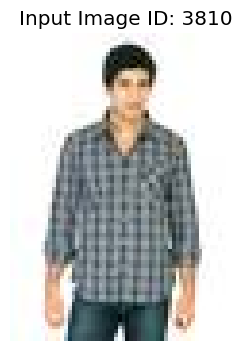

[np.float64(0.9799333539014872), np.float64(0.9652797218027371), np.float64(0.9571779717284705), np.float64(0.9565465106206106), np.float64(0.952446496549221), np.float64(0.9493821816687587)]


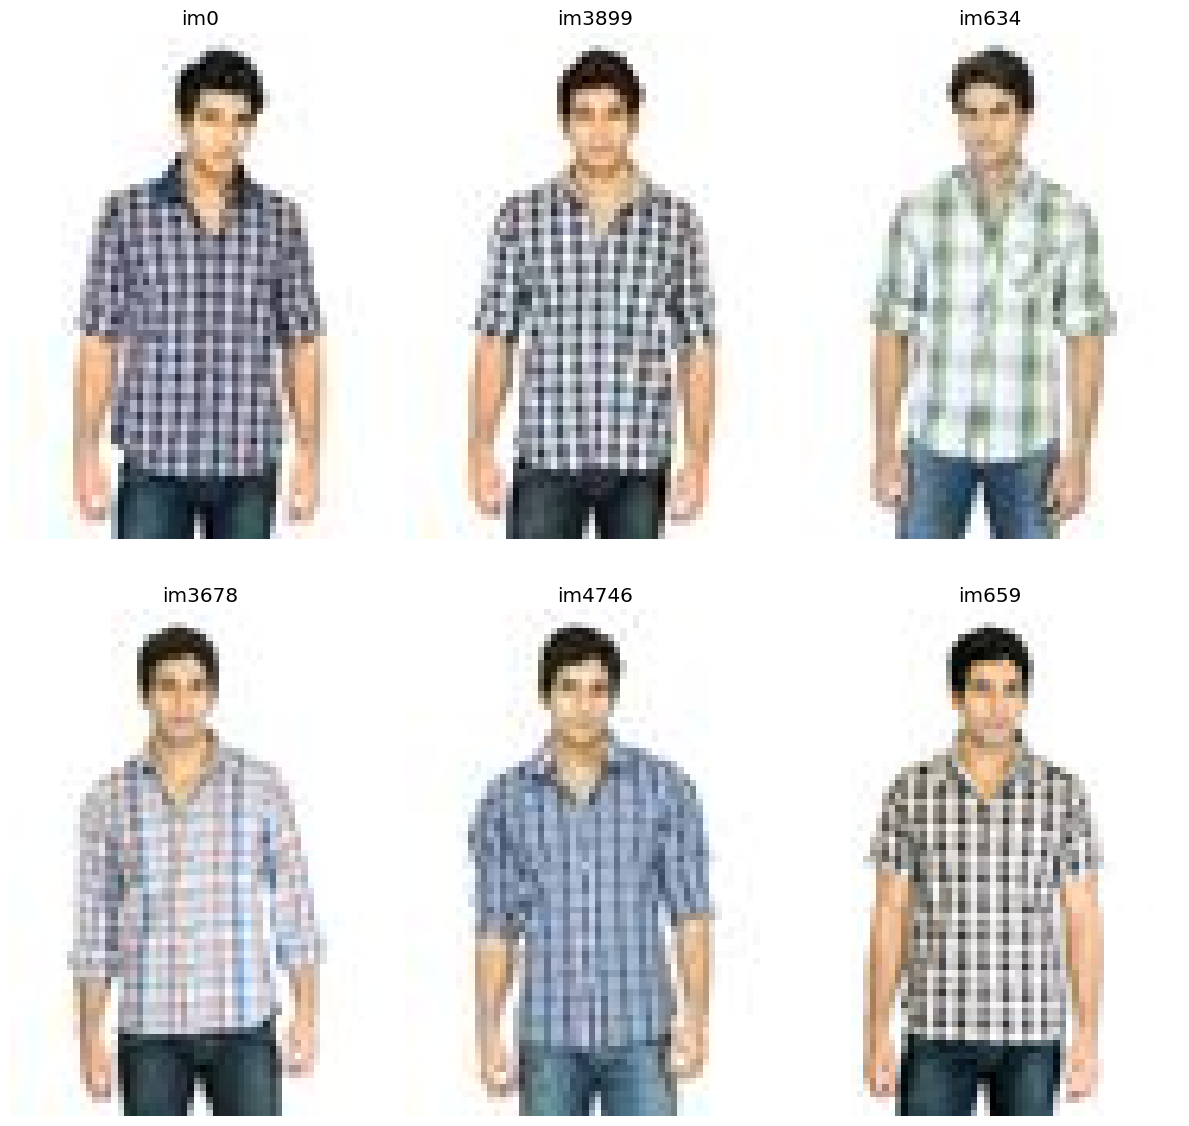

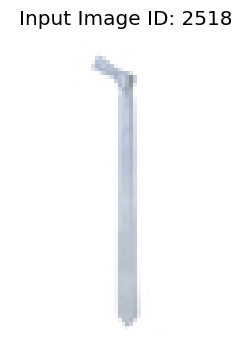

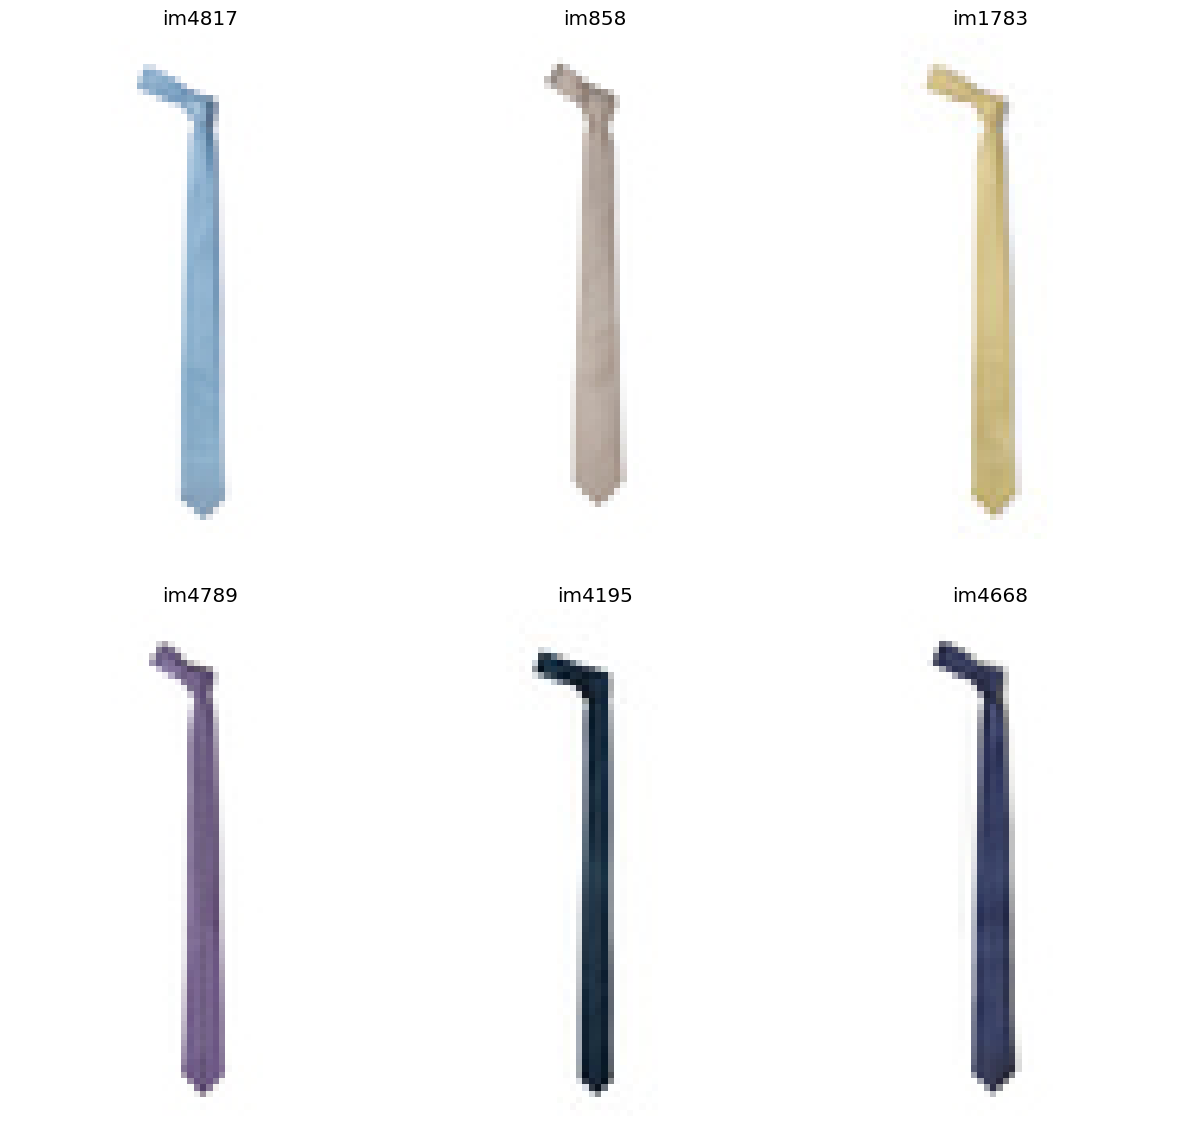

In [24]:
# Example 1: Recommendations for image with index 3810
Rec_viz_image(3810)

# Example 2: Recommendations for image with index 2518 (tie)
Rec_viz_image(2518)


In [25]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import torch
from torch.autograd import Variable
from pandas.core.common import flatten
import pandas as pd

# Function: Recommend similar images based on a custom user image
def recm_user_input(image_filename):
    # Load user image and convert it to RGB
    img = Image.open('/content/user_test_images/' + image_filename).convert('RGB')

    # Apply same transformations as we did for dataset images
    t_img = Variable(standardize(convert_tensor(s_data(img))).unsqueeze(0))

    # Initialize empty tensor for storing output embedding
    embeddings = torch.zeros(512)

    # Define a forward hook to extract features
    def select_d(m, i, o):
        embeddings.copy_(o.data.reshape(o.data.size(1)))

    # Register the hook
    hlayer = layer.register_forward_hook(select_d)

    # Run the image through the model
    resnetmodel(t_img)

    # Remove hook
    hlayer.remove()

    # Calculate cosine similarity with all embeddings in df_embs
    cs = cosine_similarity(embeddings.unsqueeze(0), df_embs)
    cs_list = list(flatten(cs))

    # Create a DataFrame of similarity scores
    cs_df = pd.DataFrame(cs_list, columns=['Score'])
    cs_df = cs_df.sort_values(by='Score', ascending=False)

    # Show top 10 similarity scores
    print(cs_df['Score'][:10])

    # Get top 10 image indices
    top10_indices = cs_df[:10].index.tolist()

    # Retrieve image filenames from original df using indices
    images_list = df.iloc[top10_indices]['image'].tolist()

    # Display input image
    img_print = Image.open('/content/user_test_images/' + image_filename)
    plt.figure(figsize=(4, 4))
    plt.imshow(img_print)
    plt.title('Input Image')
    plt.axis('off')
    plt.show()

    # Dictionary of similar images
    figures = {
        'im'+str(i): Image.open('/content/fashion-product-images-small/images/' + img_file)
        for i, img_file in enumerate(images_list)
    }

    # Plot the top 10 recommended images (2 rows × 5 columns)
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for index, name in enumerate(figures):
        axes.ravel()[index].imshow(figures[name])
        axes.ravel()[index].set_title(name)
        axes.ravel()[index].set_axis_off()
    plt.tight_layout()
